In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from functions import preprocessing, drop_columns

In [2]:
train_raw = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train_extended = pd.read_csv('data/train_extended.csv')

In [3]:
train_raw2 = preprocessing(train_raw, train_extended)
train = train_raw2[(train_raw2.TeledyneRampWeight!=74283)].copy(deep=True)
print(f'Number of rows dropped = {len(train_raw) - len(train)} ({round((len(train_raw) - len(train))*100/len(train_raw), 2)}%)')

Number of rows dropped = 5707 (0.75%)


In [62]:
train_extended = preprocessing(train_extended, train_extended)
train_extended = train_extended[(train_extended.TeledyneRampWeight!=74283)]

In [4]:
train.head()

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,ArrivalScheduled,BlockTimeScheduled,Adults,Children,Freight,Infants,Bags,TeledyneRampWeight
0,181142302,221,SPRZK,197.0,Max,Scheduled Flight,FR,Ryanair Sun,EMA-BUD,2022-01-24 09:55:00,2022-01-24 12:30:00,152.0,112.0,6.0,0.0,2.0,43.0,62075.0
1,178908306,3373,9HQEC,189.0,NG,Scheduled Flight,FR,Malta Air,TRN-MLA,2020-03-09 09:00:00,2020-03-09 11:00:00,114.0,18.0,0.0,0.0,0.0,7.0,62002.0
2,178886981,2814,9HQCN,189.0,NG,Scheduled Flight,FR,Malta Air,STN-CGN,2020-01-06 07:35:00,2020-01-06 08:50:00,66.0,126.0,5.0,0.0,0.0,19.0,58029.0
3,180538798,6893,SPRKP,189.0,NG,Scheduled Flight,FR,Ryanair Sun,DTM-KTW,2020-12-11 07:15:00,2020-12-11 08:45:00,84.0,84.0,5.0,0.0,1.0,8.0,56070.0
4,178863684,2156,EIDWJ,189.0,NG,Scheduled Flight,FR,Ryanair DAC,BHX-AGP,2020-02-07 15:20:00,2020-02-07 18:05:00,170.0,175.0,2.0,0.0,0.0,47.0,68315.0


### **Great Circle Distance**

Calculating the distance from the starting airport to the destination airport.

**NOTE:** Not all airports are in one database so we will use different ones combined and manually add any missing.

In [5]:
# pip install -U airportsdata
import airportsdata
airports = airportsdata.load('IATA')

In [6]:
airports2 = pd.read_csv('GlobalAirportDatabase.txt',sep=':',header=None)[[1,14,15]]
airports2.columns = ['IATA','Latitude','Longitude']
airports2 = airports2.drop_duplicates(subset='IATA').dropna()
airports2 = airports2.set_index('IATA').T.to_dict('list')

In [7]:
# Adding one airport that was missing
airports2['SZY'] = [53.4879,20.9465]

In [8]:
def gc_dis(airport_coords1, airport_coords2):
    """
    Return the great-circle distance between two sets of coordinates in radians.
    """
    haversin = lambda alpha: np.sin(alpha/2)**2
    # Earth's radius, km
    R = 6378.14
    (phi1, lambda1), (phi2, lambda2) = airport_coords1, airport_coords2
    d = 2 * R * np.arcsin(np.sqrt(haversin(phi2-phi1) + np.cos(phi1) * np.cos(phi2) * haversin(lambda2-lambda1)))
    return d


def gc_distance(ScheduledRoute, airports, airports2):
    """
    Return the great-circle distance between two Airports.
    """
    StartAirport = ScheduledRoute.split('-')[0]
    DestinationAirport = ScheduledRoute.split('-')[1]

    if (StartAirport in list(airports.keys())):
        airport_coords1 = (
            np.radians(float(airports[StartAirport]['lat'])),
            np.radians(float(airports[StartAirport]['lon']))
            )
    elif (StartAirport in list(airports2.keys())):
        airport_coords1 = (
            np.radians(float(airports2[StartAirport][0])),
            np.radians(float(airports2[StartAirport][1]))
            )
    else:
        airport_coords1 = 0

    if (DestinationAirport in list(airports.keys())):
        airport_coords2 = (
            np.radians(float(airports[DestinationAirport]['lat'])),
            np.radians(float(airports[DestinationAirport]['lon']))
            )

    elif (DestinationAirport in list(airports2.keys())):
        airport_coords2 = (
            np.radians(float(airports2[DestinationAirport][0])),
            np.radians(float(airports2[DestinationAirport][1]))
            )
    
    else:
        airport_coords2 = 0


    if (airport_coords1!=0) & (airport_coords2!=0):
        return gc_dis(airport_coords1,airport_coords2)
    else:
        return 0

In [9]:
train['GreatCircleDistance'] = [gc_distance(i,airports,airports2) for i in train.ScheduledRoute]
test['GreatCircleDistance'] = [gc_distance(i,airports,airports2) for i in test.ScheduledRoute]

C:\Users\leofr\AppData\Local\Temp/ipykernel_4612/1708603138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GreatCircleDistance'] = [gc_distance(i,airports,airports2) for i in train.ScheduledRoute]


In [10]:
train['GreatCircleDistance'] = train.GreatCircleDistance.replace(0,np.nan)
train.GreatCircleDistance.isna().sum()

C:\Users\leofr\AppData\Local\Temp/ipykernel_4612/701991590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GreatCircleDistance'] = train.GreatCircleDistance.replace(0,np.nan)


0

In [11]:
test['GreatCircleDistance'] = test.GreatCircleDistance.replace(0,np.nan)
test.GreatCircleDistance.isna().sum()

0

In [12]:
# extra_features_train = pd.read_csv('extra_data/distance_and_weight_train.csv')
# extra_features_test = pd.read_csv('extra_data/distance_and_weight_test.csv')

# train = train.merge(extra_features_train,on='FlightID')
# test = test.merge(extra_features_test,on='FlightID')

### **Total Estimated Weight**

Weight = Empty Airplane + Passengers + Bags + Freight + Fuel + Carry-on

**AIRPLANE WEIGHT**<br>

AircraftTypeGroup:
- NG = Boeing 737-800 = 41140 kg
- Airbus = Airbus A320 = 42600 kg
- Max = Boeing 737-8200 = 45070 kg

**PASSENGER WEIGHT**<br>

- Average weight of adult (Europe) = 70.8 
- Average weight of child = 25
- Average weight of infant = 9

**BAGS WEIGHT**
- Average weight of bag = 20

**FREIGHT WEIGHT**<br>
- Already in kg

**FUEL WEIGHT**<br>

"Empirical analysis shows, that it takes on average ~ 0.2 kg fuel to transport 1 kg of weight over a distance of 1000 km. It also takes an additional ~ 0.02 to 0.03 kg fuel per 1000 km for every kg of weight added."

Source: https://digitalcollection.zhaw.ch/bitstream/11475/1896/6/Steinegger_Fuel_Economy_as_a_Function_of_Weight_and_Distance_v1-1.pdf

In [97]:
train[train.Adults==0].TeledyneRampWeight.mean()

58147.91860465116

In [138]:
airplane_weight = {'NG':41140,'Airbus':42600,'Max':45070}
airplane_fuel_hour = {'NG':2500,'Airbus':2400,'Max':2300}
weights = {'Adult': 70, 'Child': 25, 'Infant': 9, 'Bag': 15, 'Carry-on':9}

def calculate_weight(data, weights):
    total_weight=[]
    
    for index, row in data.iterrows():
        if int(row.Adults) == 0:
            total_weight.append(58147.9)

        elif int(row.Freight) > 10000:
            total_weight.append(61808)
            
        else:
            int_weight = airplane_weight[row.AircraftTypeGroup] \
                + (int(row.Adults) * weights['Adult']) \
                    + (int(row.Children) * weights['Child']) \
                        + (int(row.Infants) * weights['Infant']) \
                            + (int(row.Bags) * weights['Bag'])  \
                                + float(row.Freight) \
                                    + ((int(row.Adults) + int(row.Children)) * weights['Carry-on'])
            fuel_weight1 = ((row.BlockTimeScheduled-21) / 60) * airplane_fuel_hour[row.AircraftTypeGroup]
            fuel_weight = fuel_weight1 + (0.03*fuel_weight1) + (0.5 * airplane_fuel_hour[row.AircraftTypeGroup])
            total_weight.append(int_weight + fuel_weight + 4068)
    return total_weight

# weights = {}
# best_mae = 999999999
# for f in fuel_ratio:
#     total_weight = calculate_weight(train,adult,child,infant,bag_weight,f)
#     mae = mean_absolute_error(train.TeledyneRampWeight,total_weight)
#     if mae < best_mae:
#         best_mae = mae
#         weights['Adult'] = adult
#         weights['Child'] = child
#         weights['Infant'] = infant
#         weights['Bag'] = bag_weight
#         weights['Fuel_Ratio'] = f

In [55]:
train['TotalEstimatedWeight4'] = calculate_weight(train,weights)

C:\Users\leofr\AppData\Local\Temp/ipykernel_4612/1163752005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TotalEstimatedWeight4'] = calculate_weight(train,weights)


In [139]:
test['TotalEstimatedWeight4'] = calculate_weight(test,weights)

In [34]:
train['Diff'] = train.TeledyneRampWeight - train.TotalEstimatedWeight2

C:\Users\leofr\AppData\Local\Temp/ipykernel_4612/4050842491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Diff'] = train.TeledyneRampWeight - train.TotalEstimatedWeight2


In [42]:
train[train.Adults==0][['AircraftTypeGroup','Adults','Children','Bags','BlockTimeScheduled','TeledyneRampWeight','TotalEstimatedWeight','TotalEstimatedWeight2','Diff']].head(20)

,AircraftTypeGroup,Adults,Children,Bags,BlockTimeScheduled,TeledyneRampWeight,TotalEstimatedWeight,TotalEstimatedWeight2,Diff
2647,NG,0.0,0.0,6.0,53.0,48451.0,43853.333333,45761.333333,2689.666667
3858,NG,0.0,0.0,30.0,95.0,56487.0,46015.833333,55555.833333,931.166667
3905,NG,0.0,0.0,22.0,154.0,60841.0,48427.916667,55423.916667,5417.083333
4516,NG,0.0,0.0,31.0,165.0,56578.0,49035.000000,58893.000000,-2315.000000
4609,NG,0.0,0.0,24.0,78.0,62419.0,45196.250000,52828.250000,9590.750000
5312,NG,0.0,0.0,5.0,163.0,51626.0,48559.166667,50149.166667,1476.833333
5351,NG,0.0,0.0,12.0,97.0,59608.0,45831.666667,49647.666667,9960.333333
6301,NG,0.0,0.0,3.0,78.0,50828.0,44881.250000,45835.250000,4992.750000
6375,NG,0.0,0.0,14.0,112.0,58900.0,46505.416667,50957.416667,7942.583333
7014,NG,0.0,0.0,68.0,180.0,67063.0,50233.750000,71857.750000,-4794.750000


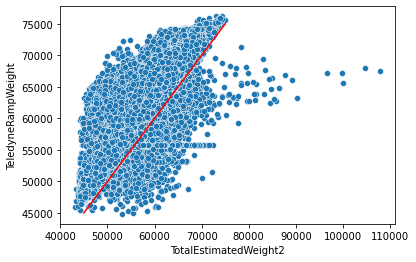

In [37]:
sns.scatterplot(data=train, x='TotalEstimatedWeight2', y='TeledyneRampWeight')
plt.plot([45000,75000],[45000,75000],color='red');

c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


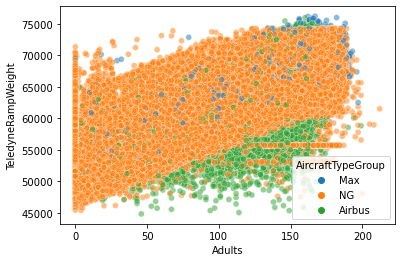

In [13]:
sns.scatterplot(data=train, x='Adults', y='TeledyneRampWeight',hue='AircraftTypeGroup',alpha=0.5);

c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


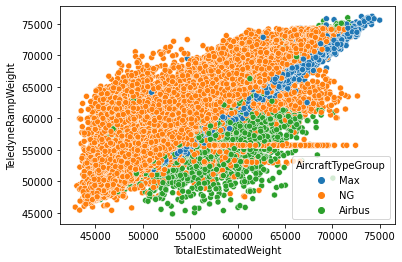

In [58]:
sns.scatterplot(data=train, x='TotalEstimatedWeight', y='TeledyneRampWeight',hue='AircraftTypeGroup');

In [38]:
train.groupby('AircraftTypeGroup').agg({'Diff':'mean'})

,Diff
AircraftTypeGroup,
Airbus,2173.519768
Max,2116.228449
NG,4193.699280


In [51]:
np.mean(train[train.Adults!=0].TeledyneRampWeight - train[train.Adults!=0].TotalEstimatedWeight3)

4068.0553520841704

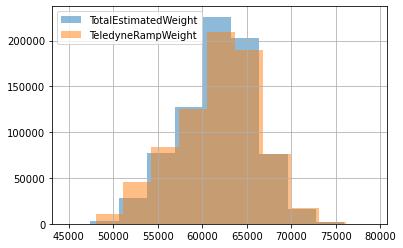

In [56]:
train.TotalEstimatedWeight4.hist(alpha=0.5,label='TotalEstimatedWeight')
train.TeledyneRampWeight.hist(alpha=0.5,label='TeledyneRampWeight')
plt.legend();

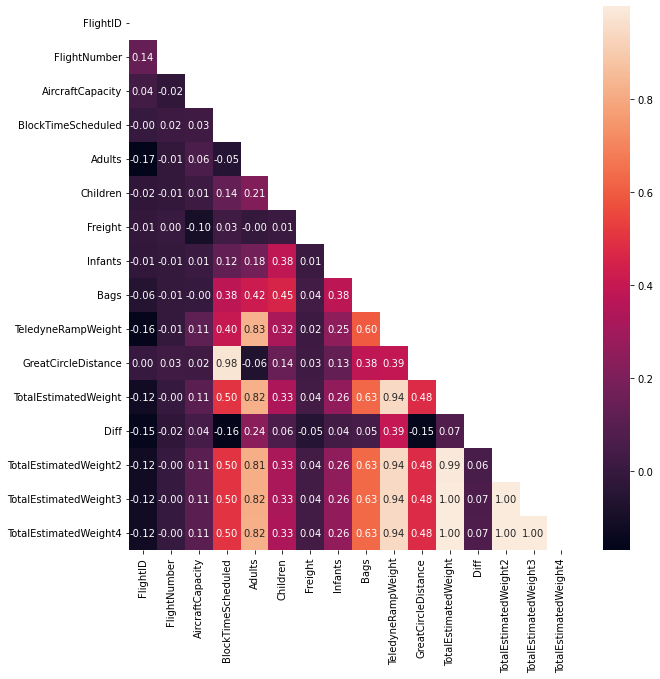

In [57]:
train_corr = train.corr()
matrix = np.triu(train_corr)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train_corr,annot=True,mask=matrix,fmt = '.2f');

In [64]:
train.dtypes

FlightID                   int64
FlightNumber               int64
AircraftRegistration      object
AircraftCapacity         float64
AircraftTypeGroup         object
ServiceDescription        object
Carrier                   object
AOCDescription            object
ScheduledRoute            object
DepartureScheduled        object
ArrivalScheduled          object
BlockTimeScheduled       float64
Adults                   float64
Children                 float64
Freight                  float64
Infants                  float64
Bags                     float64
TeledyneRampWeight       float64
GreatCircleDistance      float64
TotalEstimatedWeight     float64
Adults2                   object
Diff                     float64
TotalEstimatedWeight2    float64
TotalEstimatedWeight3    float64
TotalEstimatedWeight4    float64
dtype: object

In [143]:
my_vars = ['AircraftTypeGroup','Adults','Children','Freight','Bags']

In [144]:
train.AircraftTypeGroup.unique()

array(['Max', 'NG', 'Airbus'], dtype=object)

In [145]:
train2 = train[my_vars].copy(deep=True)
test2 = test[my_vars].copy(deep=True)

X_train = pd.get_dummies(train2,drop_first=True)
X_test = pd.get_dummies(test2,drop_first=True)

X_test['Freight'] = [x if x < 10000 else 0 for x in X_test.Freight ]

In [146]:
lr = LinearRegression()
lr.fit(X_train, train_extended.PlannedZeroFuelWeight)
zf_pred_train = lr.predict(X_train)
zf_pred = lr.predict(X_test)

In [147]:
mean_absolute_error(train_extended.PlannedZeroFuelWeight, zf_pred_train)

1136.532426130279

In [148]:
train['ZeroFuelPred'] = zf_pred_train
test['ZeroFuelPred'] = zf_pred

C:\Users\leofr\AppData\Local\Temp/ipykernel_4612/607614409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ZeroFuelPred'] = zf_pred_train


In [123]:
train[['FlightID','GreatCircleDistance','TotalEstimatedWeight4','ZeroFuelPred']].to_csv('extra_data/distance_and_weight_train.csv',index=False)
test[['FlightID','GreatCircleDistance','TotalEstimatedWeight4','ZeroFuelPred']].to_csv('extra_data/distance_and_weight_test.csv',index=False)